# CUDA vs CPU performace testing on Multiple Resolutions


In [8]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")

DetermineInertiaGravityWaveExactSurfaceElevation (generic function with 1 method)

In [2]:
using BenchmarkTools

import CUDA

# Initial 1:1 test

In [5]:
mpasOcean = MPAS_Ocean(CODE_ROOT * "InertiaGravityWaveMesh",
                    "base_mesh.nc",
                    "mesh.nc")
mpasOcean.nCells

10000

In [12]:
etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, 2, 3, 1e-2)

inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0)

In [13]:
bench = @benchmark forward_backward_step!(mpasOcean)

BenchmarkTools.Trial: 2738 samples with 1 evaluation.
 Range (min … max):  1.789 ms …   3.963 ms  ┊ GC (min … max): 0.00% … 51.64%
 Time  (median):     1.801 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.825 ms ± 187.482 μs  ┊ GC (mean ± σ):  0.91% ±  4.65%

   ▂██▅▂                                                       
  ▄█████▆▄▄▃▃▃▃▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂ ▃
  1.79 ms         Histogram: frequency by time        1.97 ms <

 Memory estimate: 625.00 KiB, allocs estimate: 10000.

In [7]:
mpasOceanCuda = MPAS_Ocean_CUDA(mpasOcean)

In [8]:
bench2 = @benchmark begin
    CUDA.@sync begin forward_backward_step_cuda!(mpasOceanCuda) end
end

BechmarkTools.Trial: 10000 samples with 1 evaluations.
 Range (min … max):  18.681 μs …  4.199 ms  ┊ GC (min … max): 0.00% … 98.71%
 Time  (median):     49.997 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   49.587 μs ± 60.595 μs  ┊ GC (mean ± σ):  1.66% ±  1.40%

  ▃▄▂                                       ▁▅██▆▁            ▂
  ███▆▄▅▄▄▄▁▃▁▄▃▄▁▃▃▄▁▄▅▅▅▄▅▃▃▄▁▃▃▃▅▄▅▅▅▅▄▄▇██████▇▆▆▆▆▅▄▅▅▅▄ █
  18.7 μs      Histogram: log(frequency) by time      59.8 μs <

 Memory estimate: 8.97 KiB, allocs estimate: 178.

# Compare benchmarks of 6 meshes
see how performance scales with resolution 

In [14]:
base_path = CODE_ROOT * "ConvergenceStudyMeshes/"

"/Users/robertstrauss/Desktop/MPAS_Ocean_Julia/ConvergenceStudyMeshes/"

In [10]:
function time_resolution_test(; step = forward_backward_step!, cuda=false, initfunc=planeWaveInit!, cases=6, periodicity="Periodic")
    nncells = []

    ttimes = []

    cases = 6

    for iCase in 1:cases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$iCase.nc"
        else
            base_mesh_file_name = "culled_mesh_$iCase.nc"
        end
        mesh_file_name = "mesh_$iCase.nc"
        mpasOcean = MPAS_Ocean(base_path * periodicity, base_mesh_file_name, mesh_file_name, periodicity=periodicity)

        println("Now benchmarking case $iCase of $cases, with $(mpasOcean.nCells) cells.")
        
        (initfunc)(mpasOcean)
        
        prefix = do
        if cuda
            mpasOcean = MPAS_Ocean_CUDA(mpasOcean)
            prefix = CUDA.@sync
        end
        
        bench = @benchmark begin
            (prefix) begin ($step)($mpasOcean) end
        end
    
        append!(ttimes, [bench.times])

        append!(nncells, [mpasOcean.nCells])
    end

    means = []
    for times in ttimes
        append!(means, mean(times))
    end

    stdevs = []
    for i in 1:length(ttimes)
        append!(stdevs, sqrt(mean( (ttimes[i] .- means[i]).^2 )) )
    end
    
    return nncells, ttimes, means, stdevs
end

time_resolution_test (generic function with 1 method)

In [11]:
nncellsC, ttimesC, meansC, stdevsC = time_resolution_test(step = forward_backward_step!,
                                                    cuda=false)

Now benchmarking case 1 of 6, with 16 cells.
Now benchmarking case 2 of 6, with 64 cells.
Now benchmarking case 3 of 6, with 256 cells.
Now benchmarking case 4 of 6, with 1024 cells.
Now benchmarking case 5 of 6, with 4096 cells.
Now benchmarking case 6 of 6, with 16384 cells.


(Any[16, 64, 256, 1024, 4096, 16384], Any[[107443.0, 107476.0, 107492.0, 107508.0, 107547.0, 107566.0, 107593.0, 107596.0, 107607.0, 107636.0  …  3.316064e6, 3.322261e6, 3.324777e6, 3.326576e6, 3.333535e6, 3.36781e6, 3.395674e6, 3.418111e6, 3.430124e6, 3.511812e6], [433759.0, 434275.0, 434373.0, 434418.0, 434435.0, 434449.0, 434471.0, 434549.0, 434611.0, 434701.0  …  3.80183e6, 3.803247e6, 3.839491e6, 3.851207e6, 3.884129e6, 3.925797e6, 3.931157e6, 3.986524e6, 4.010011e6, 4.06935e6], [1.765045e6, 1.765164e6, 1.766152e6, 1.766791e6, 1.767266e6, 1.76728e6, 1.767286e6, 1.767326e6, 1.767647e6, 1.767656e6  …  5.247494e6, 5.26881e6, 5.280503e6, 5.301223e6, 5.318004e6, 5.323174e6, 5.368075e6, 5.522044e6, 5.682086e6, 5.778838e6], [7.152575e6, 7.155002e6, 7.158215e6, 7.162252e6, 7.166797e6, 7.16784e6, 7.168446e6, 7.169369e6, 7.171633e6, 7.17212e6  …  1.0778497e7, 1.0779918e7, 1.0785875e7, 1.0809941e7, 1.0838012e7, 1.0887199e7, 1.1010114e7, 1.1037049e7, 1.1100124e7, 1.1542762e7], [2.897542e7, 2.

In [12]:
nncellsG, ttimesG, meansG, stdevsG = time_resolution_test(
                                        step = forward_backward_step_cuda!,
                                        cuda=true
    )

Now benchmarking case 1 of 6, with 16 cells.
Now benchmarking case 2 of 6, with 64 cells.
Now benchmarking case 3 of 6, with 256 cells.
Now benchmarking case 4 of 6, with 1024 cells.
Now benchmarking case 5 of 6, with 4096 cells.
Now benchmarking case 6 of 6, with 16384 cells.


(Any[16, 64, 256, 1024, 4096, 16384], Any[[18938.0, 18987.0, 18996.0, 19025.0, 19027.0, 19032.0, 19033.0, 19037.0, 19047.0, 19048.0  …  48806.0, 49385.0, 52267.0, 53044.0, 54634.0, 56038.0, 58095.0, 59958.0, 72485.0, 5.315093e6], [18614.0, 18627.0, 18684.0, 18705.0, 18713.0, 18722.0, 18723.0, 18727.0, 18728.0, 18745.0  …  203752.0, 204270.0, 204826.0, 240533.0, 266166.0, 271185.0, 273756.0, 308296.0, 315228.0, 5.37475e6], [18689.0, 18695.0, 18770.0, 18772.0, 18788.0, 18802.0, 18833.0, 18834.0, 18839.0, 18839.0  …  228351.0, 229065.0, 230077.0, 240595.0, 242384.0, 264438.0, 264933.0, 266116.0, 266978.0, 5.393481e6], [18895.0, 18905.0, 18910.0, 18915.0, 18955.0, 18963.0, 18969.0, 18986.0, 18988.0, 18989.0  …  286113.0, 288294.0, 296889.0, 337624.0, 340752.0, 386689.0, 387708.0, 441316.0, 449518.0, 5.448559e6], [18535.0, 18574.0, 18668.0, 18675.0, 18676.0, 18680.0, 18704.0, 18707.0, 18739.0, 18742.0  …  296486.0, 296674.0, 298284.0, 298889.0, 299723.0, 304572.0, 305277.0, 311650.0, 370403

## Plot benchmarks against resolution

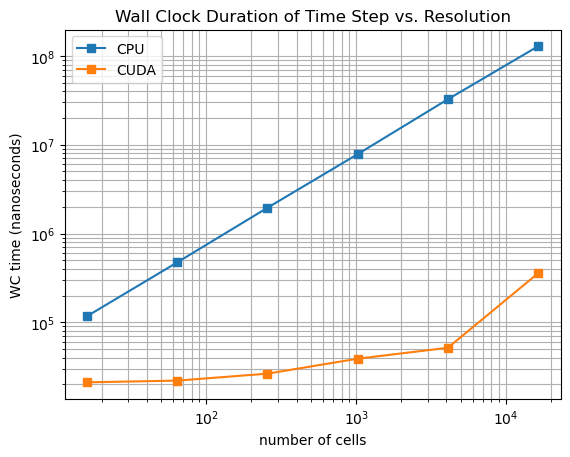

PyObject Text(0.5, 1.0, 'Wall Clock Duration of Time Step vs. Resolution')

In [13]:
fig, ax = subplots(1,1)

ax.set_xscale("log")
ax.set_yscale("log")

plot(nncellsC, meansC, label="CPU", marker="s") # yerr=stdevsC
plot(nncellsG, meansG, label="CUDA", marker="s") # yerr=stdevsG,

ylabel("WC time (nanoseconds)")
xlabel("number of cells")

legend()

grid(which="both")

title("Wall Clock Duration of Time Step vs. Resolution")

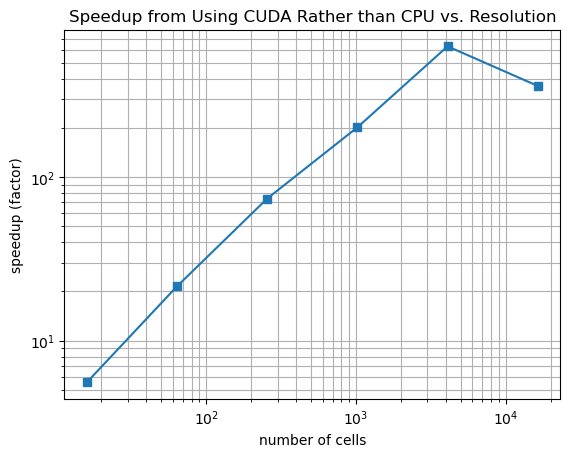

PyObject Text(0.5, 1.0, 'Speedup from Using CUDA Rather than CPU vs. Resolution')

In [14]:
fig, ax = subplots(1,1)

ax.set_xscale("log")
ax.set_yscale("log")

plot(nncellsC, meansC ./ meansG, marker="s")

ylabel("speedup (factor)")
xlabel("number of cells")

grid(which="both")

title("Speedup from Using CUDA Rather than CPU vs. Resolution")